<a href="https://colab.research.google.com/github/evangeliapant/Wildfire-Detection-using-Image-Analysis/blob/main/wildfire_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.6/303.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
# Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input # Import preprocess_input from the specific model module
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image
import wandb
from wandb.integration.keras import WandbCallback
from google.colab import drive

In [ ]:
# Initialize W&B
wandb.init(project="wildfire_detection_improved6")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the base directory for your data in Google Drive
base_dir = '/content/drive/My Drive/data'
train_dir = os.path.join(base_dir, 'train')
validate_dir = os.path.join(base_dir, 'validate')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
# Image dimensions
img_height, img_width = 224, 224
batch_size = 32  # Increased batch size for faster processing

# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # MobileNetV2 preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validate_generator = val_test_datagen.flow_from_directory(
    validate_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

# Check data distribution
train_class_counts = train_generator.classes
validate_class_counts = validate_generator.classes

print(f'Training data distribution: {np.bincount(train_class_counts)}')
print(f'Validation data distribution: {np.bincount(validate_class_counts)}')

Found 3017 images belonging to 2 classes.
Found 701 images belonging to 2 classes.
Training data distribution: [1252 1765]
Validation data distribution: [316 385]


In [ ]:
# Model setup
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Unfreeze more layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Add custom layers on top of MobileNetV2
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Single unit for binary classification
])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, mode='min'),
    WandbCallback()
]

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [ ]:
# Fit the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validate_generator,
    callbacks=callbacks
)

# Save the model
model.save('wildfire_model.h5')

# Evaluate the model
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
95/95 [==============================] - ETA: 0s - loss: 0.3211 - accuracy: 0.8459

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240728_065315-f1vwjfns/files/model-best)... Done. 0.4s


95/95 [==============================] - 796s 8s/step - loss: 0.3211 - accuracy: 0.8459 - val_loss: 0.3588 - val_accuracy: 0.9030 - lr: 1.0000e-04
Epoch 2/10
95/95 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9857

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240728_065315-f1vwjfns/files/model-best)... Done. 0.2s


95/95 [==============================] - 639s 7s/step - loss: 0.0451 - accuracy: 0.9857 - val_loss: 0.1462 - val_accuracy: 0.9686 - lr: 1.0000e-04
Epoch 3/10
95/95 [==============================] - 623s 7s/step - loss: 0.0262 - accuracy: 0.9930 - val_loss: 0.1628 - val_accuracy: 0.9700 - lr: 1.0000e-04
Epoch 4/10
95/95 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9973

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240728_065315-f1vwjfns/files/model-best)... Done. 0.4s


95/95 [==============================] - 638s 7s/step - loss: 0.0099 - accuracy: 0.9973 - val_loss: 0.1138 - val_accuracy: 0.9786 - lr: 1.0000e-04
Epoch 5/10
95/95 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9947

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240728_065315-f1vwjfns/files/model-best)... Done. 0.2s


95/95 [==============================] - 647s 7s/step - loss: 0.0144 - accuracy: 0.9947 - val_loss: 0.1033 - val_accuracy: 0.9857 - lr: 1.0000e-04
Epoch 6/10
95/95 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9967

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240728_065315-f1vwjfns/files/model-best)... Done. 0.3s


95/95 [==============================] - 642s 7s/step - loss: 0.0094 - accuracy: 0.9967 - val_loss: 0.0607 - val_accuracy: 0.9900 - lr: 1.0000e-04
Epoch 7/10
95/95 [==============================] - 619s 7s/step - loss: 0.0036 - accuracy: 0.9980 - val_loss: 0.1167 - val_accuracy: 0.9843 - lr: 1.0000e-04
Epoch 8/10
95/95 [==============================] - 617s 6s/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 0.0902 - val_accuracy: 0.9886 - lr: 1.0000e-04
Epoch 9/10
95/95 [==============================] - 632s 7s/step - loss: 0.0100 - accuracy: 0.9973 - val_loss: 0.2987 - val_accuracy: 0.9629 - lr: 1.0000e-04
Epoch 10/10
12/95 [==>...........................] - ETA: 8:53 - loss: 0.0183 - accuracy: 0.9948

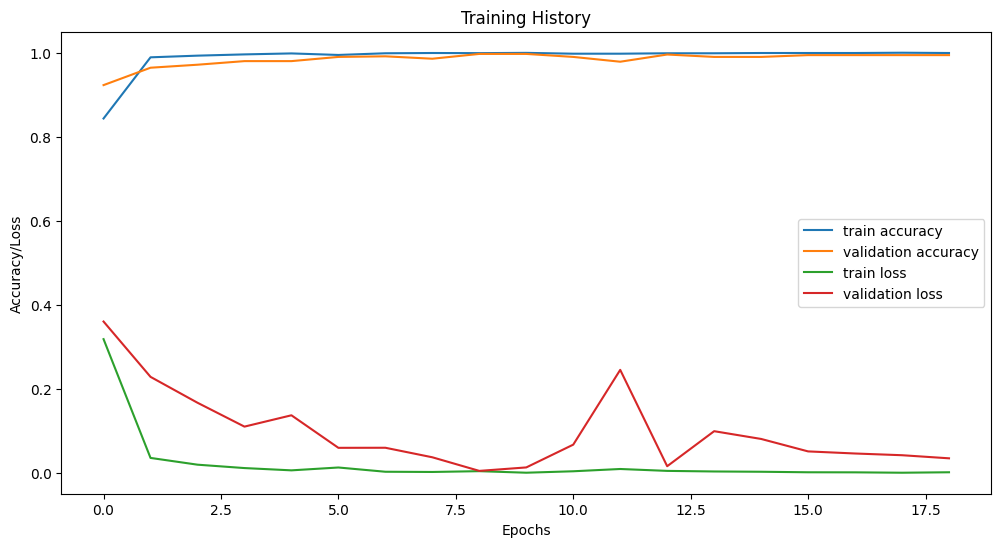

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.title('Training History')
plt.savefig('training_history.png')

In [ ]:
# Close the plot to avoid any issues
plt.close()

# Log the plot image to W&B
wandb.log({"training_history": wandb.Image('training_history.png')})

70/70 [==============================] - 87s 1s/step


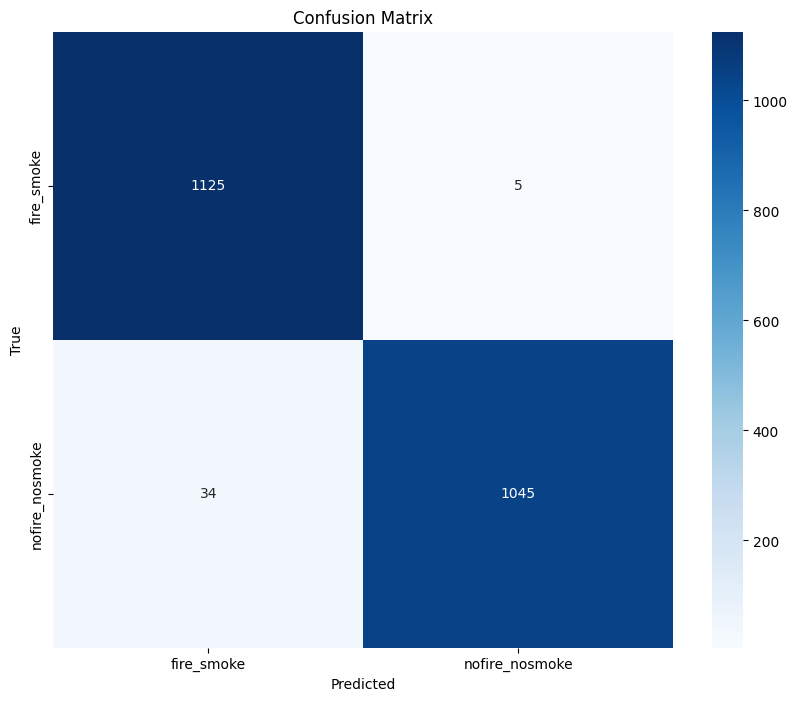

In [ ]:
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).ravel()
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

In [ ]:
# Close the plot to avoid any issues
plt.close()

# Log the plot image to W&B
wandb.log({"confusion_matrix": wandb.Image('confusion_matrix.png')})

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_labels))

wandb.log({
    "test_accuracy": test_accuracy,
    "classification_report": classification_report(y_true, y_pred, target_names=class_labels, output_dict=True),
})

                precision    recall  f1-score   support

    fire_smoke       0.97      1.00      0.98      1130
nofire_nosmoke       1.00      0.97      0.98      1079

      accuracy                           0.98      2209
     macro avg       0.98      0.98      0.98      2209
  weighted avg       0.98      0.98      0.98      2209



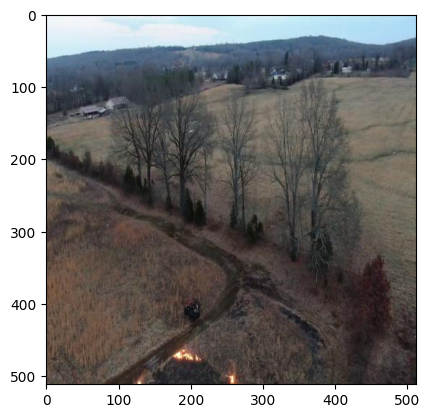

Misclassified image: fire_smoke/fire-1422-_png.rf.59d88704d078bfeca063366ce5c56fc2.jpg


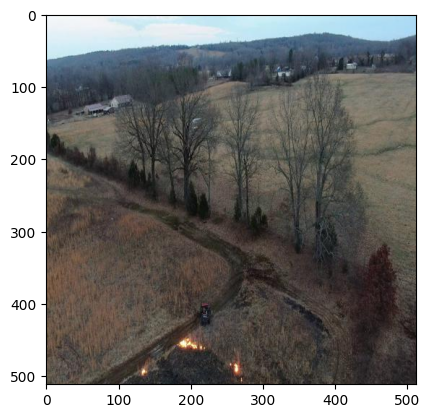

Misclassified image: fire_smoke/fire-1427-_png.rf.91d558198aed63b8146554a36258481f.jpg


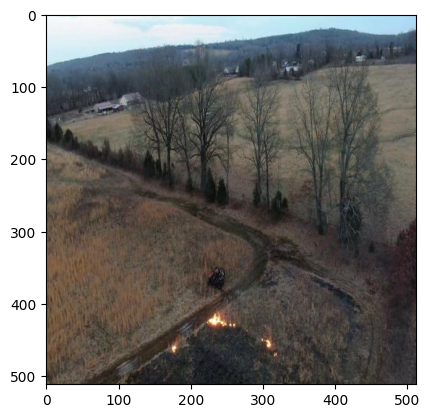

Misclassified image: fire_smoke/fire-1433-_png.rf.4ad78a69e3f2ac628caebaf4e3bfbb78.jpg


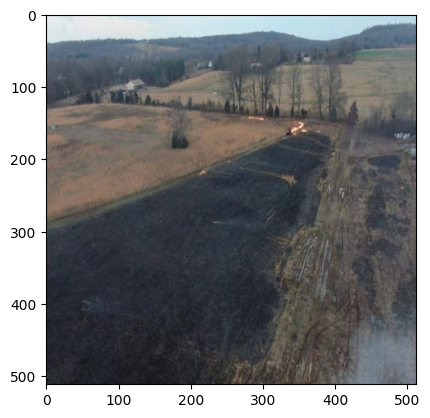

Misclassified image: fire_smoke/fire-1545-_png.rf.b5e0f2732dc053c0479d66d94d089754.jpg


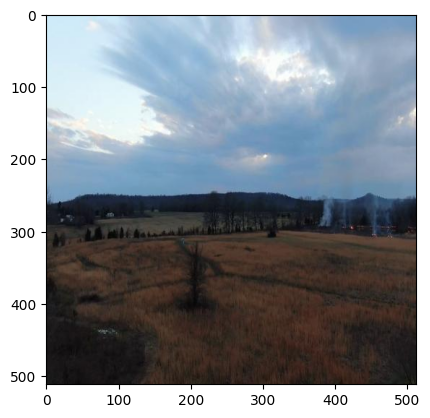

Misclassified image: fire_smoke/fire-953-_png.rf.d81674d40c1ea21d32c9e18176c0247c.jpg


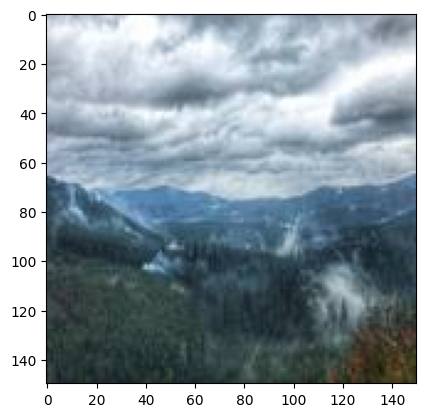

Misclassified image: nofire_nosmoke/50380847112_db217aea45_o.jpg


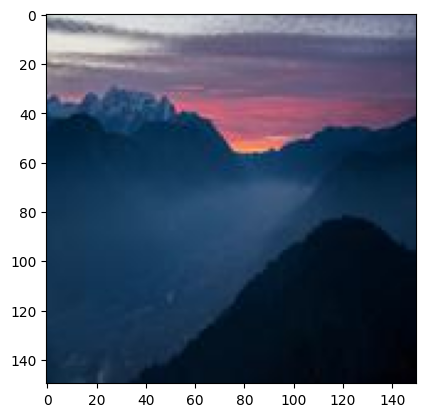

Misclassified image: nofire_nosmoke/ales-krivec-sTEg_SLAyUs-unsplash.jpg


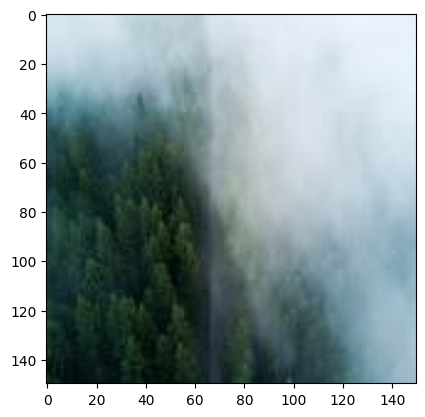

Misclassified image: nofire_nosmoke/arnold-dogelis-JN782tahBLI-unsplash.jpg


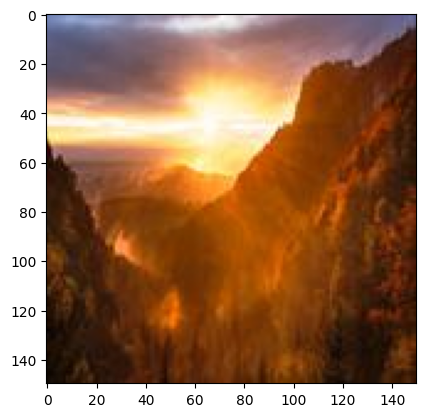

Misclassified image: nofire_nosmoke/artem-sapegin-8c6eS43iq1o-unsplash.jpg


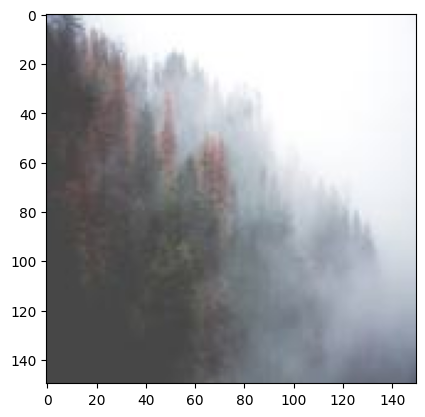

Misclassified image: nofire_nosmoke/austin-schmid-zQ-y4Gj8194-unsplash.jpg


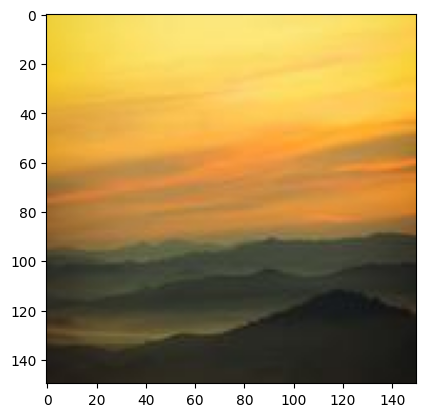

Misclassified image: nofire_nosmoke/chris-barbalis-SIbpq4Lvzdk-unsplash.jpg


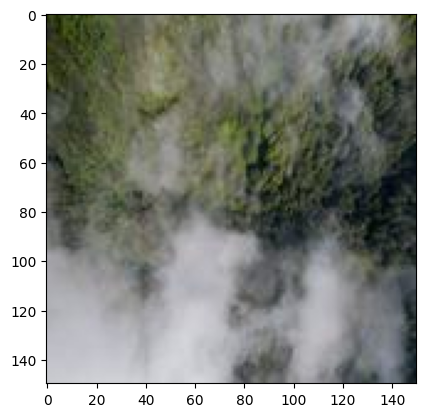

Misclassified image: nofire_nosmoke/dan-meyers-TWENdzEF6-o-unsplash.jpg


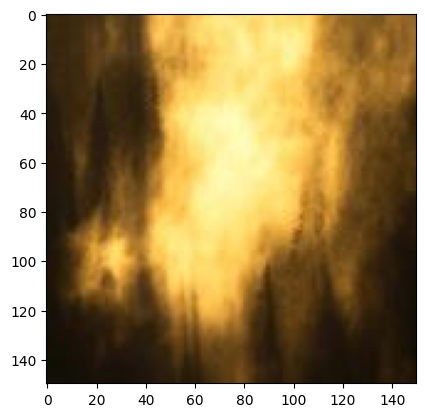

Misclassified image: nofire_nosmoke/daniel-mirlea-sS7GkbDdpMY-unsplash.jpg


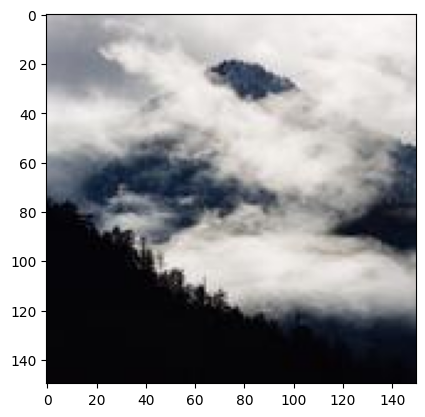

Misclassified image: nofire_nosmoke/dave-hoefler-9V-hT3P_7KI-unsplash.jpg


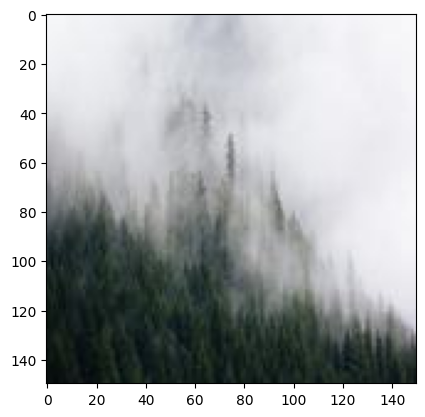

Misclassified image: nofire_nosmoke/dave-hoefler-U-Dhokv9iXk-unsplash.jpg


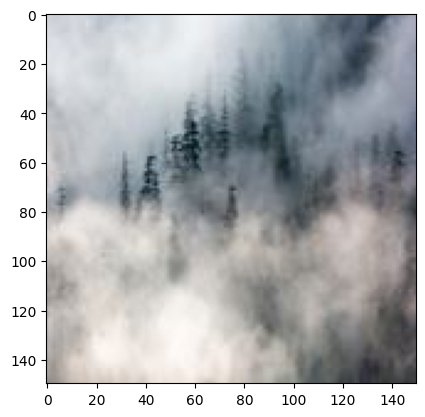

Misclassified image: nofire_nosmoke/dave-hoefler-od287vQyufw-unsplash.jpg


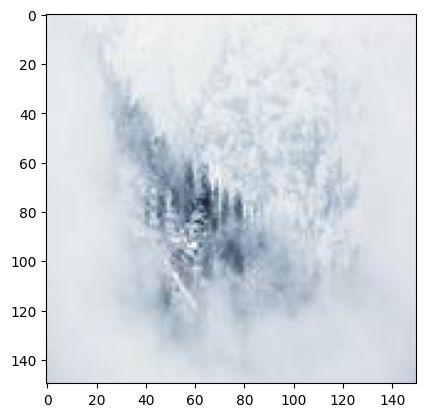

Misclassified image: nofire_nosmoke/dave-hoefler-pe2X3tQ2EvQ-unsplash.jpg


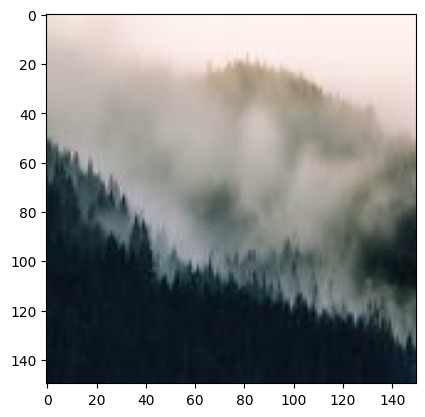

Misclassified image: nofire_nosmoke/dave-hoefler-rcE3_D-u2NE-unsplash.jpg


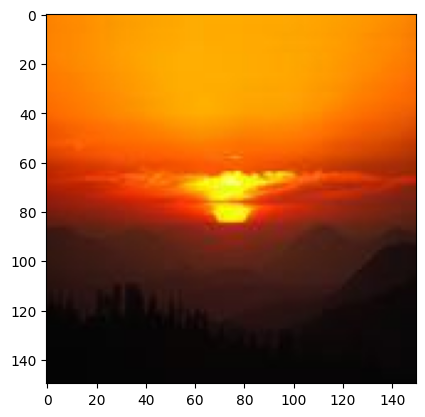

Misclassified image: nofire_nosmoke/david-mullins-3Jnws1iRSwk-unsplash.jpg


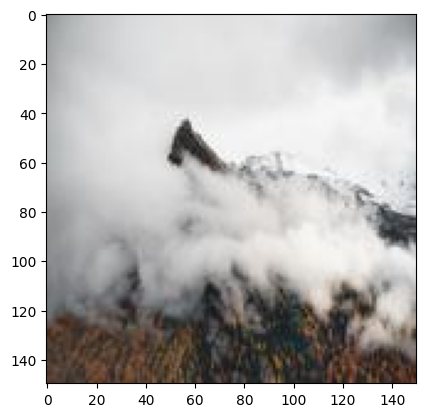

Misclassified image: nofire_nosmoke/eberhard-grossgasteiger-srX1E4V6tlo-unsplash.jpg


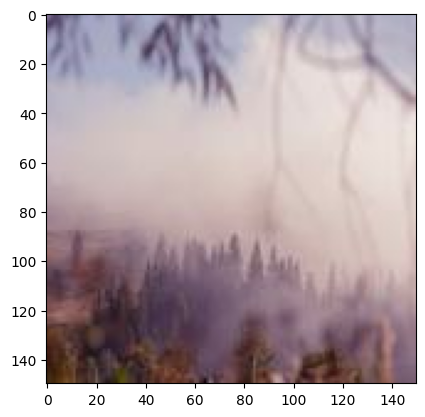

Misclassified image: nofire_nosmoke/elena-mozhvilo-JZYHskOBOlg-unsplash.jpg


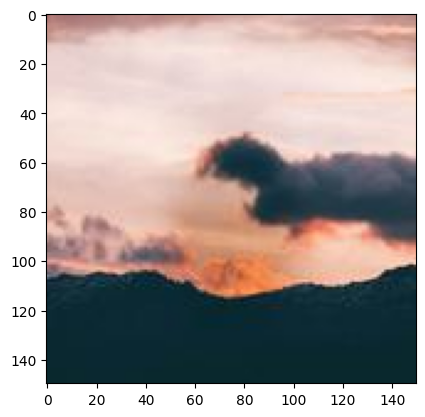

Misclassified image: nofire_nosmoke/eric-muhr-C6AY64q2l84-unsplash.jpg


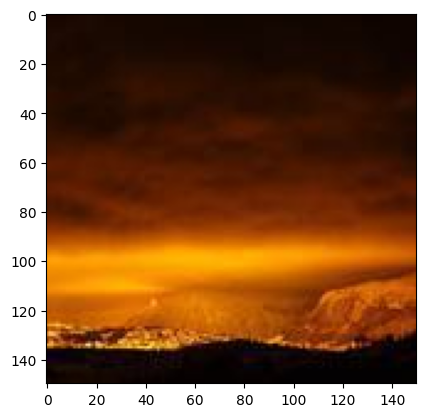

Misclassified image: nofire_nosmoke/harry-jaschhof-E3OGWdm6C_g-unsplash.jpg


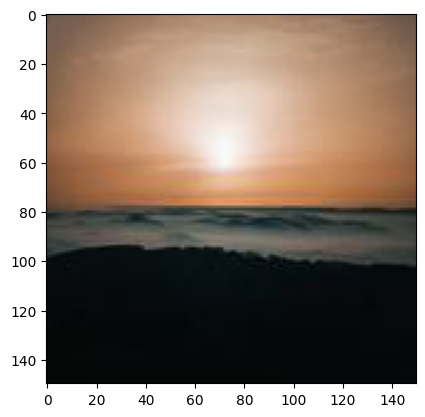

Misclassified image: nofire_nosmoke/honza-reznik-uaU8NExAvwM-unsplash.jpg


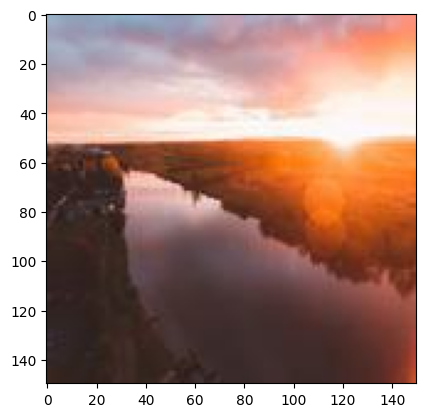

Misclassified image: nofire_nosmoke/humphrey-muleba-X9oGih7E_oU-unsplash.jpg


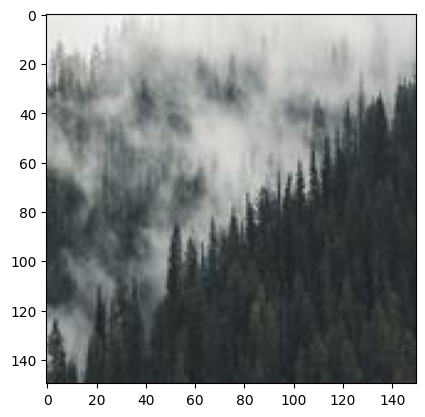

Misclassified image: nofire_nosmoke/isaac-mitchell-Ws4cyJn6Is0-unsplash.jpg


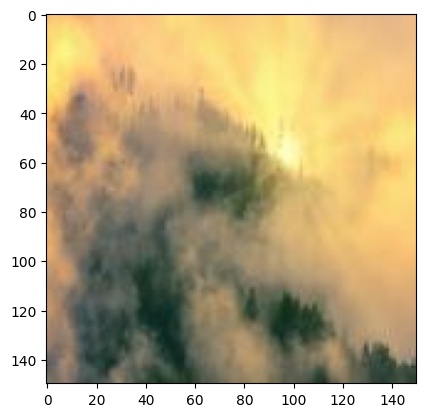

Misclassified image: nofire_nosmoke/johannes-plenio-ZRJwl3M7q2g-unsplash.jpg


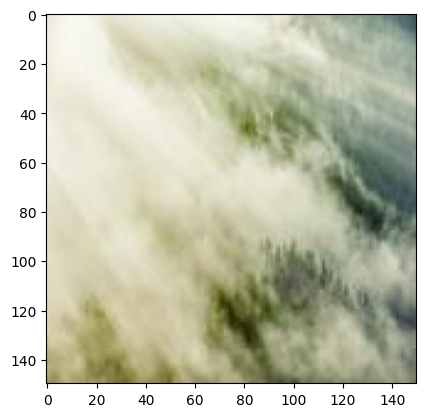

Misclassified image: nofire_nosmoke/johannes-plenio-a9PDBZO7Ivk-unsplash.jpg


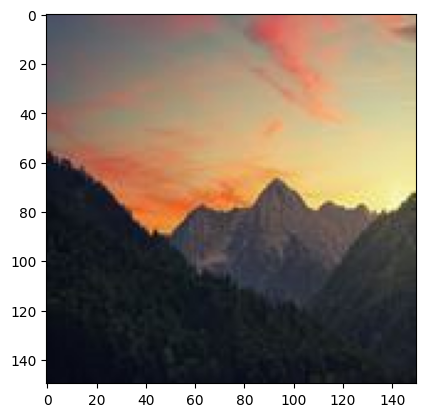

Misclassified image: nofire_nosmoke/johannes-plenio-sY5llOA25Ck-unsplash.jpg


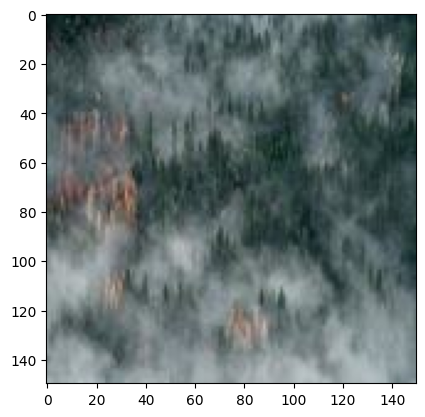

Misclassified image: nofire_nosmoke/john-towner-89PFnHKg8HE-unsplash.jpg


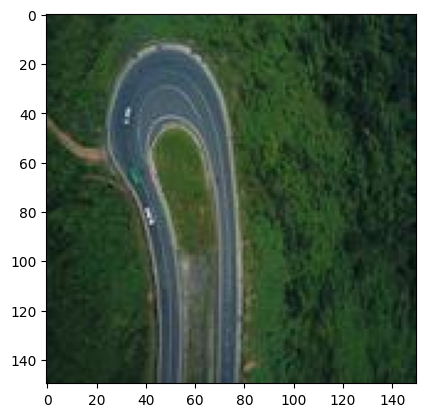

Misclassified image: nofire_nosmoke/jordan-opel-N1AFXixF4qQ-unsplash.jpg


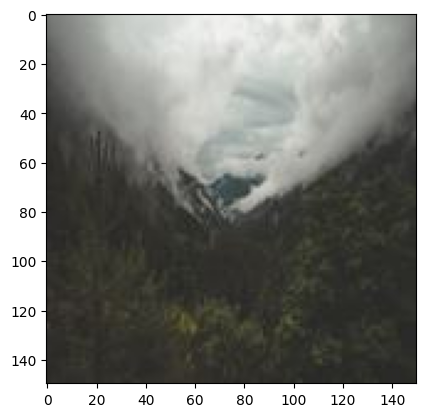

Misclassified image: nofire_nosmoke/jp-valery-W9iWetsS4EE-unsplash.jpg


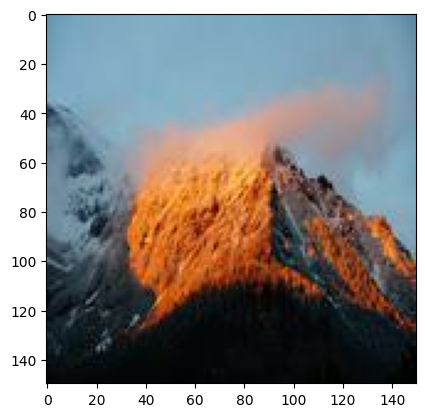

Misclassified image: nofire_nosmoke/kaidi-guo-iq0EoeLNoy8-unsplash.jpg


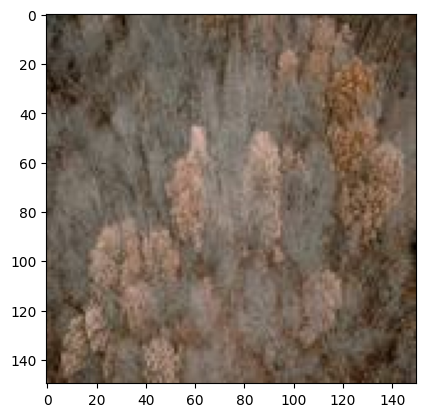

Misclassified image: nofire_nosmoke/keagan-henman-digbEZQyrsY-unsplash.jpg


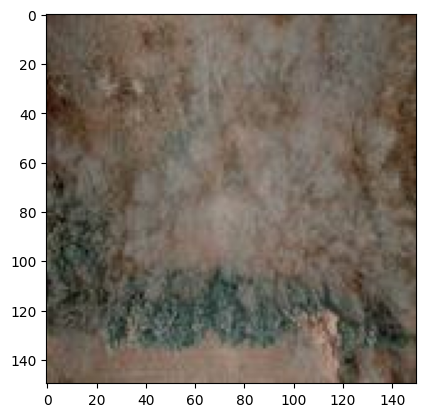

Misclassified image: nofire_nosmoke/keagan-henman-wyoPyihLCug-unsplash.jpg


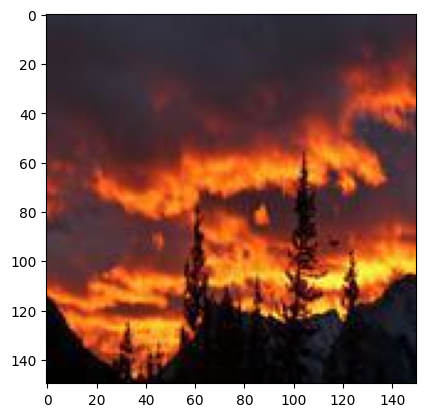

Misclassified image: nofire_nosmoke/kym-mackinnon-2ui_UtznZ2g-unsplash.jpg


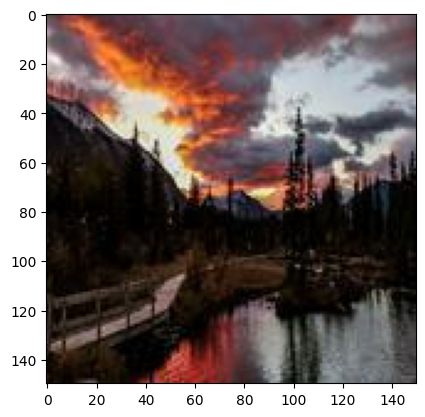

Misclassified image: nofire_nosmoke/kym-mackinnon-3UysRR0fVIk-unsplash.jpg


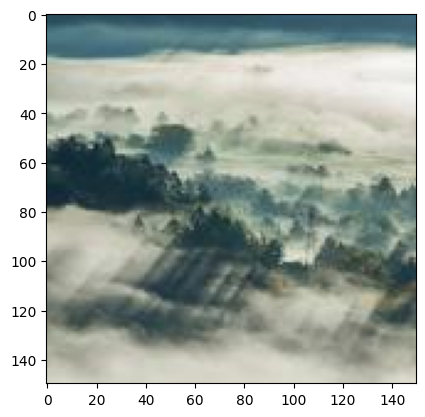

Misclassified image: nofire_nosmoke/neven-krcmarek-50HS3AzJsvQ-unsplash.jpg


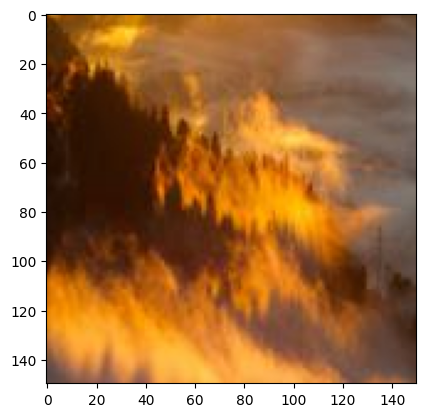

Misclassified image: nofire_nosmoke/neven-krcmarek-ZM7PgZ1zU2k-unsplash.jpg


In [ ]:
# Analyze misclassifications
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]
misclassified_images = [test_generator.filenames[i] for i in misclassified_indices]

for img_path in misclassified_images:
    img = Image.open(os.path.join(test_dir, img_path))
    plt.imshow(img)
    plt.show()

    # Analyze the misclassification and suggest changes
    # For example, if images with certain characteristics are misclassified,
    # suggest specific data augmentations or model adjustments
    print(f"Misclassified image: {img_path}")